# KNN Model Training and Backtesting Experiment

This notebook trains KNN models with different training periods to examine the impact of training data size on performance:
1. 30-day training period
2. 90-day training period  
3. Half-dataset training period

All models use seed=654 for reproducibility and follow proper time-series validation to prevent data leakage.

In [5]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta

# Add the features directory to path - navigate from models/code to features
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'features'))
from trend_indicator_pipeline_pkg import TrendIndicatorPipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline, CorrelationIndicatorPipeline, FractalDimensionPipeline

from arcticdb.version_store.helper import ArcticMemoryConfig
from arcticdb import Arctic

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from pycaret.classification import setup, compare_models, save_model, predict_model, pull, tune_model, finalize_model, create_model

print("All packages imported successfully!")

All packages imported successfully!


In [6]:
# Load dataset with proper time-series handling
print("Loading dataset...")
df = pd.read_csv("E:\\Coding\\Crypto_Research\\data\\BTCUSD_2023-1min_ML_with_FDs.csv")

# Drop NaN values
df = df.dropna()

# Convert timestamp and sort chronologically to ensure proper time-series order
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

print(f"Dataset loaded: {df.shape[0]} records")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
print(f"Total duration: {(df['Timestamp'].max() - df['Timestamp'].min()).days} days")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

Loading dataset...
Dataset loaded: 427042 records
Date range: 2023-02-10 03:16:00 to 2023-12-26 08:56:00
Total duration: 319 days

First 5 rows:
            Timestamp  Unnamed: 0.1  Unnamed: 0     Open     High      Low  \
0 2023-02-10 03:16:00         50398       50398  21851.5  21856.5  21851.2   
1 2023-02-10 03:17:00         50399       50399  21853.2  21853.2  21851.2   
2 2023-02-10 03:18:00         50400       50400  21854.3  21855.1  21847.1   
3 2023-02-10 03:19:00         50401       50401  21849.3  21849.9  21840.3   
4 2023-02-10 03:20:00         50402       50402  21840.9  21853.0  21840.2   

     Close    Volume        ema_7d       ema_20d  ...    bb_mid_20d  \
0  21853.3  0.000218  22893.243714  22435.379752  ...  22953.582628   
1  21852.7  0.000121  22893.037277  22435.339289  ...  22953.610139   
2  21849.9  0.000298  22892.830326  22435.298635  ...  22953.637677   
3  21841.1  0.000497  22892.621670  22435.257373  ...  22953.665097   
4  21845.7  0.000385  22892.413

In [7]:
# Define time-series splits with proper chronological ordering
# CRITICAL: We use time-based splits to prevent data leakage

start_date = df['Timestamp'].min()
end_date = df['Timestamp'].max()

# Calculate split dates based on chronological order
split_30_day = start_date + timedelta(days=30)
split_90_day = start_date + timedelta(days=90)
split_half = start_date + (end_date - start_date) / 2

print("Time-series split configuration:")
print(f"Start date: {start_date}")
print(f"End date: {end_date}")
print(f"30-day split: {split_30_day}")
print(f"90-day split: {split_90_day}")
print(f"Half-dataset split: {split_half}")

# Create the three datasets with proper time-series splits
datasets = {}

# 1. 30-day training data
train_30 = df[df['Timestamp'] <= split_30_day].copy()
test_30 = df[df['Timestamp'] > split_30_day].copy()
datasets['30_day'] = {'train': train_30, 'test': test_30, 'split_date': split_30_day}

# 2. 90-day training data
train_90 = df[df['Timestamp'] <= split_90_day].copy()
test_90 = df[df['Timestamp'] > split_90_day].copy()
datasets['90_day'] = {'train': train_90, 'test': test_90, 'split_date': split_90_day}

# 3. Half-dataset training data
train_half = df[df['Timestamp'] <= split_half].copy()
test_half = df[df['Timestamp'] > split_half].copy()
datasets['half'] = {'train': train_half, 'test': test_half, 'split_date': split_half}

# Print dataset sizes
print("\nDataset sizes (ensuring no data leakage):")
for name, data in datasets.items():
    train_size = len(data['train'])
    test_size = len(data['test'])
    total_size = train_size + test_size
    train_start = data['train']['Timestamp'].min()
    train_end = data['train']['Timestamp'].max()
    test_start = data['test']['Timestamp'].min()
    test_end = data['test']['Timestamp'].max()
    
    print(f"\n{name.upper()} SPLIT:")
    print(f"  Train: {train_size:,} records ({train_start} to {train_end})")
    print(f"  Test:  {test_size:,} records ({test_start} to {test_end})")
    print(f"  Total: {total_size:,} records")
    print(f"  Split ratio: {train_size/total_size:.1%} train / {test_size/total_size:.1%} test")
    
    # CRITICAL CHECK: Ensure no overlap between train and test
    if train_end >= test_start:
        print(f"    WARNING: Potential data leakage detected!")
    else:
        print(f"   No data leakage: {(test_start - train_end).total_seconds()/60:.0f} minute gap")

Time-series split configuration:
Start date: 2023-02-10 03:16:00
End date: 2023-12-26 08:56:00
30-day split: 2023-03-12 03:16:00
90-day split: 2023-05-11 03:16:00
Half-dataset split: 2023-07-19 18:06:00

Dataset sizes (ensuring no data leakage):

30_DAY SPLIT:
  Train: 40,915 records (2023-02-10 03:16:00 to 2023-03-12 03:16:00)
  Test:  386,127 records (2023-03-12 03:17:00 to 2023-12-26 08:56:00)
  Total: 427,042 records
  Split ratio: 9.6% train / 90.4% test
   No data leakage: 1 minute gap

90_DAY SPLIT:
  Train: 123,538 records (2023-02-10 03:16:00 to 2023-05-11 03:16:00)
  Test:  303,504 records (2023-05-11 03:17:00 to 2023-12-26 08:56:00)
  Total: 427,042 records
  Split ratio: 28.9% train / 71.1% test
   No data leakage: 1 minute gap

HALF SPLIT:
  Train: 215,456 records (2023-02-10 03:16:00 to 2023-07-19 18:06:00)
  Test:  211,586 records (2023-07-19 18:07:00 to 2023-12-26 08:56:00)
  Total: 427,042 records
  Split ratio: 50.5% train / 49.5% test
   No data leakage: 1 minute gap

In [8]:
# Train all 3 KNN models with seed=654
seed = 654
models = {}
model_performance = {}

print("Training KNN models with different training periods...")
print("=" * 60)

for dataset_name, data in datasets.items():
    print(f"\nTraining KNN Model for {dataset_name.upper()} dataset")
    print("-" * 40)
    
    train_df = data['train']
    split_date = data['split_date']
    
    print(f"Training data: {len(train_df):,} records")
    print(f"Training period: {train_df['Timestamp'].min()} to {train_df['Timestamp'].max()}")
    
    # Set up PyCaret with consistent seed
    clf_setup = setup(
        data=train_df,
        target='future_trend',
        session_id=seed,
        train_size=0.7,
        fold_shuffle=True,
        fold=12,
        verbose=False,
        ignore_features=['Unnamed: 0.1', 'Timestamp', 'Unnamed: 0', 'future_close', 'future_return']
    )
    
    # Create and train KNN model
    knn_model = create_model('knn', verbose=False)
    
    # Tune the model
    knn_tuned = tune_model(knn_model, verbose=False)
    
    # Finalize the model (train on full training dataset)
    knn_final = finalize_model(knn_tuned)
    
    # Store the model
    models[dataset_name] = knn_final
    
    # Get model performance metrics
    model_results = pull()
    best_metrics = model_results.iloc[0]  # Get best performing configuration
    
    model_performance[dataset_name] = {
        'dataset': dataset_name,
        'training_records': len(train_df),
        'training_period': f"{train_df['Timestamp'].min()} to {train_df['Timestamp'].max()}",
        'split_date': split_date,
        'accuracy': best_metrics['Accuracy'],
        'auc': best_metrics['AUC'],
        'recall': best_metrics['Recall'],
        'precision': best_metrics['Prec.'],
        'f1': best_metrics['F1'],
        'kappa': best_metrics['Kappa']
    }
    
    print(f" Model trained successfully!")
    print(f"   Accuracy: {best_metrics['Accuracy']:.4f}")
    print(f"   AUC: {best_metrics['AUC']:.4f}")
    print(f"   F1: {best_metrics['F1']:.4f}")

print(f"\n All 3 KNN models trained successfully with seed={seed}!")
print(f"Models stored in: models dictionary")
print(f"Performance metrics stored in: model_performance dictionary")

Training KNN models with different training periods...

Training KNN Model for 30_DAY dataset
----------------------------------------
Training data: 40,915 records
Training period: 2023-02-10 03:16:00 to 2023-03-12 03:16:00
 Model trained successfully!
   Accuracy: 0.9992
   AUC: 0.9990
   F1: 0.9987

Training KNN Model for 90_DAY dataset
----------------------------------------
Training data: 123,538 records
Training period: 2023-02-10 03:16:00 to 2023-05-11 03:16:00
 Model trained successfully!
   Accuracy: 0.9960
   AUC: 0.9993
   F1: 0.9937

Training KNN Model for HALF dataset
----------------------------------------
Training data: 215,456 records
Training period: 2023-02-10 03:16:00 to 2023-07-19 18:06:00
 Model trained successfully!
   Accuracy: 0.9962
   AUC: 0.9980
   F1: 0.9923

 All 3 KNN models trained successfully with seed=654!
Models stored in: models dictionary
Performance metrics stored in: model_performance dictionary


Training Performance Comparison:
       dataset training_records accuracy     auc      f1
30_day  30_day            40915   0.9992   0.999  0.9987
90_day  90_day           123538    0.996  0.9993  0.9937
half      half           215456   0.9962   0.998  0.9923


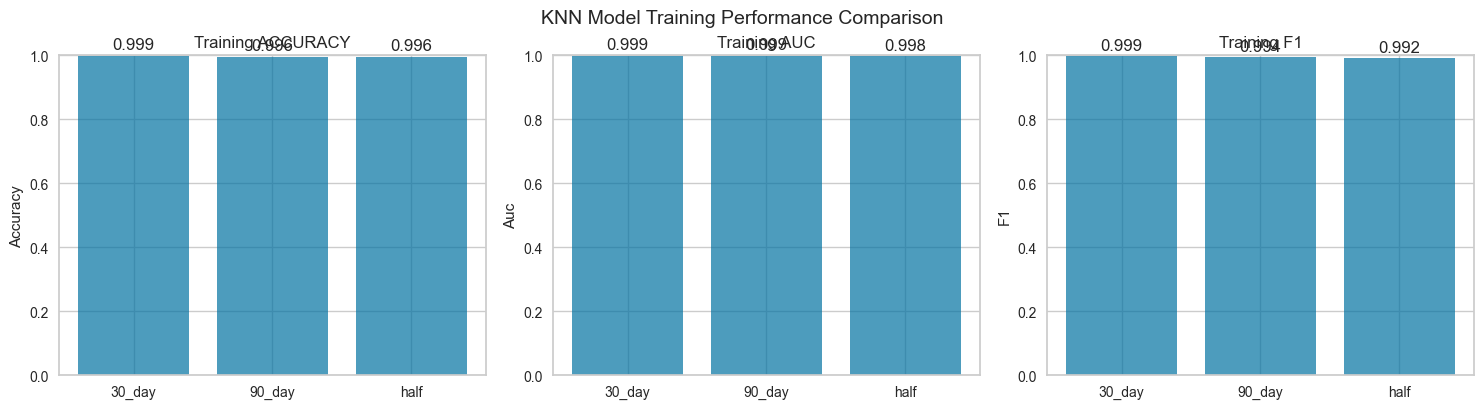

In [9]:
# Display training performance comparison
print("Training Performance Comparison:")
print("=" * 80)

performance_df = pd.DataFrame(model_performance).T
print(performance_df[['dataset', 'training_records', 'accuracy', 'auc', 'f1']].to_string())

# Visualize training performance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['accuracy', 'auc', 'f1']
dataset_names = list(model_performance.keys())

for i, metric in enumerate(metrics):
    values = [model_performance[name][metric] for name in dataset_names]
    axes[i].bar(dataset_names, values, alpha=0.7)
    axes[i].set_title(f'Training {metric.upper()}')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_ylim(0, 1)
    
    # Add value labels on bars
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.suptitle('KNN Model Training Performance Comparison', y=1.02, fontsize=14)
plt.show()

In [10]:
# Fee-Aware Backtesting for all 3 KNN models
initial_capital = 10000
fee_pct = 0.0075  # 0.75% fee per trade
stop_loss_pct = 0.05  # 5% stop loss
strategy_results = {}

print("Running fee-aware backtesting for all 3 KNN models...")
print("=" * 60)

for dataset_name, model in models.items():
    test_data = datasets[dataset_name]['test']
    split_date = datasets[dataset_name]['split_date']
    
    print(f'\nBacktesting {dataset_name.upper()} model')
    print("-" * 40)
    print(f"Test data: {len(test_data):,} records")
    print(f"Test period: {test_data['Timestamp'].min()} to {test_data['Timestamp'].max()}")
    print(f"Training cutoff: {split_date}")

    # CRITICAL: Predict ONLY on test data (future data relative to training)
    pred_df = predict_model(model, data=test_data.copy(), verbose=False)
    pred_df['timestamp'] = pd.to_datetime(pred_df['Timestamp'])
    pred_df.set_index('timestamp', inplace=True)
    pred_df = pred_df.sort_index()  # Ensure chronological order

    # Verify no data leakage in predictions
    if pred_df.index.min() <= split_date:
        print(f"  WARNING: Potential data leakage in predictions!")
    else:
        print(f" No data leakage: Predictions start after training cutoff")

    # Initialize backtesting variables
    position = 0
    cash = initial_capital
    trade_log = []
    portfolio_values = []
    in_trade = False
    entry_price = 0
    entry_time = None
    total_invested = 0
    entry_fees = 0

    # Backtesting loop - SAME LOGIC AS ORIGINAL
    for i in range(len(pred_df)):
        row = pred_df.iloc[i]
        signal = row['prediction_label']
        current_price = row['Close']
        date = row.name

        # Entry Logic: Buy signal
        if signal == 1 and not in_trade:
            available_for_investment = cash
            gross_position_value = available_for_investment / (1 + fee_pct)
            position = gross_position_value / current_price
            entry_fees = gross_position_value * fee_pct
            total_invested = gross_position_value + entry_fees
            entry_price = current_price
            entry_time = date
            cash = 0
            in_trade = True

        # Exit Logic: Fee-aware exit or Stop-loss
        elif in_trade:
            current_value = position * current_price
            price_change = (current_value - total_invested) / total_invested
            
            # Check for stop-loss
            stop_loss_hit = price_change <= -stop_loss_pct
            
            # Fee-aware exit logic
            fee_checker = (current_price - entry_price) / entry_price > fee_pct * 2
            sell_signal = signal == 0
            fee_aware_exit = sell_signal and fee_checker
            
            if fee_aware_exit or stop_loss_hit:
                # Calculate exit with fees
                gross_exit_value = position * current_price
                exit_fees = gross_exit_value * fee_pct
                exit_cash = gross_exit_value - exit_fees
                
                # Calculate PnL
                pnl = exit_cash - total_invested
                return_pct = pnl / total_invested * 100
                
                # Determine exit type
                if stop_loss_hit:
                    exit_type = 'Stop-Loss'
                elif fee_aware_exit:
                    exit_type = 'Fee-Aware Signal Exit'
                else:
                    exit_type = 'Signal Exit'
                
                # Log the trade
                trade_log.append({
                    'Entry Time': entry_time,
                    'Entry Price': round(entry_price, 2),
                    'Exit Time': date,
                    'Exit Price': round(current_price, 2),
                    'Investment ($)': round(total_invested, 2),
                    'Exit Value ($)': round(exit_cash, 2),
                    'Entry Fees ($)': round(entry_fees, 2),
                    'Exit Fees ($)': round(exit_fees, 2),
                    'PnL ($)': round(pnl, 2),
                    'Return (%)': round(return_pct, 2),
                    'Price Change (%)': round((current_price - entry_price) / entry_price * 100, 2),
                    'Fee Checker': fee_checker,
                    'Exit Type': exit_type
                })
                
                cash = exit_cash
                position = 0
                in_trade = False
                total_invested = 0

        # Record portfolio value
        if in_trade:
            current_gross_value = position * current_price
            estimated_exit_fees = current_gross_value * fee_pct
            portfolio_value = current_gross_value - estimated_exit_fees
        else:
            portfolio_value = cash
            
        portfolio_values.append({'timestamp': date, 'portfolio': portfolio_value})

    # Handle remaining position
    if in_trade:
        final_price = pred_df['Close'].iloc[-1]
        gross_exit_value = position * final_price
        exit_fees = gross_exit_value * fee_pct
        exit_cash = gross_exit_value - exit_fees
        pnl = exit_cash - total_invested
        return_pct = pnl / total_invested * 100
        
        trade_log.append({
            'Entry Time': entry_time,
            'Entry Price': round(entry_price, 2),
            'Exit Time': pred_df.index[-1],
            'Exit Price': round(final_price, 2),
            'Investment ($)': round(total_invested, 2),
            'Exit Value ($)': round(exit_cash, 2),
            'Entry Fees ($)': round(entry_fees, 2),
            'Exit Fees ($)': round(exit_fees, 2),
            'PnL ($)': round(pnl, 2),
            'Return (%)': round(return_pct, 2),
            'Price Change (%)': round((final_price - entry_price) / entry_price * 100, 2),
            'Fee Checker': (final_price - entry_price) / entry_price > fee_pct * 2,
            'Exit Type': 'End of Period'
        })
        cash = exit_cash

    # Convert to DataFrames
    port_df = pd.DataFrame(portfolio_values).set_index('timestamp')
    trade_df = pd.DataFrame(trade_log)
    
    # Save trade log
    csv_filename = f'trade_log_KNN_{dataset_name}_seed_{seed}.csv'
    trade_df.to_csv(csv_filename, index=False)
    print(f"Trade log saved: {csv_filename}")
    
    # Calculate metrics
    final_value = cash
    net_profit = final_value - initial_capital
    total_return = (net_profit / initial_capital) * 100
    
    # Portfolio returns for Sharpe ratio
    returns = port_df['portfolio'].pct_change().dropna()
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(365 * 24 * 60) if returns.std() != 0 else 0
    
    # Drawdown calculation
    peak = port_df['portfolio'].cummax()
    drawdown = (port_df['portfolio'] - peak) / peak
    max_drawdown = abs(drawdown.min()) * 100
    
    # Trade analysis
    if len(trade_df) > 0:
        win_rate = (trade_df['PnL ($)'] > 0).mean() * 100
        trade_count = len(trade_df)
        avg_trade_return = trade_df['Return (%)'].mean()
        total_fees_paid = trade_df['Entry Fees ($)'].sum() + trade_df['Exit Fees ($)'].sum()
        
        # Fee-aware exit analysis
        fee_aware_exits = (trade_df['Exit Type'] == 'Fee-Aware Signal Exit').sum()
        stop_loss_exits = (trade_df['Exit Type'] == 'Stop-Loss').sum()
        
    else:
        win_rate = 0
        trade_count = 0
        avg_trade_return = 0
        total_fees_paid = 0
        fee_aware_exits = 0
        stop_loss_exits = 0
        
    # Store results
    strategy_results[dataset_name] = {
        'dataset': dataset_name,
        'training_records': len(datasets[dataset_name]['train']),
        'test_records': len(test_data),
        'portfolio': port_df,
        'trades': trade_df,
        'final_value': final_value,
        'return_%': total_return,
        'sharpe': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'trade_count': trade_count,
        'avg_trade_return': avg_trade_return,
        'total_fees': total_fees_paid,
        'fee_aware_exits': fee_aware_exits,
        'stop_loss_exits': stop_loss_exits
    }
    
    # Print performance summary
    print(f'\nBacktesting Results:')
    print(f'Initial Capital      : ${initial_capital:,.2f}')
    print(f'Final Portfolio Value: ${final_value:,.2f}')
    print(f'Net Profit           : ${net_profit:,.2f}')
    print(f'Total Return         : {total_return:.2f}%')
    print(f'Sharpe Ratio         : {sharpe_ratio:.2f}')
    print(f'Max Drawdown         : {max_drawdown:.2f}%')
    print(f'Win Rate             : {win_rate:.2f}%')
    print(f'Total Trades         : {trade_count}')
    print(f'Avg Trade Return     : {avg_trade_return:.2f}%')
    print(f'Fee-Aware Exits      : {fee_aware_exits}')
    print(f'Stop-Loss Exits      : {stop_loss_exits}')

print(f"\n Backtesting completed for all 3 KNN models!")
print(f"Results stored in: strategy_results dictionary")

Running fee-aware backtesting for all 3 KNN models...

Backtesting 30_DAY model
----------------------------------------
Test data: 386,127 records
Test period: 2023-03-12 03:17:00 to 2023-12-26 08:56:00
Training cutoff: 2023-03-12 03:16:00
 No data leakage: Predictions start after training cutoff
Trade log saved: trade_log_KNN_30_day_seed_654.csv

Backtesting Results:
Initial Capital      : $10,000.00
Final Portfolio Value: $11,553.86
Net Profit           : $1,553.86
Total Return         : 15.54%
Sharpe Ratio         : 2.65
Max Drawdown         : 3.34%
Win Rate             : 100.00%
Total Trades         : 4
Avg Trade Return     : 3.87%
Fee-Aware Exits      : 4
Stop-Loss Exits      : 0

Backtesting 90_DAY model
----------------------------------------
Test data: 303,504 records
Test period: 2023-05-11 03:17:00 to 2023-12-26 08:56:00
Training cutoff: 2023-05-11 03:16:00
 No data leakage: Predictions start after training cutoff
Trade log saved: trade_log_KNN_90_day_seed_654.csv

Backtest

COMPREHENSIVE BACKTESTING RESULTS COMPARISON
Dataset Training Records Test Records Final Value ($) Total Return (%) Sharpe Ratio Max Drawdown (%) Win Rate (%)  Total Trades Avg Trade Return (%)
 30_DAY           40,915      386,127       11,553.86            15.54         2.65             3.34       100.00             4                 3.87
 90_DAY          123,538      303,504        8,905.64           -10.94        -1.06            22.29        42.86             7                -1.51
   HALF          215,456      211,586       10,307.44             3.07         0.54             7.18        80.00             5                 0.67


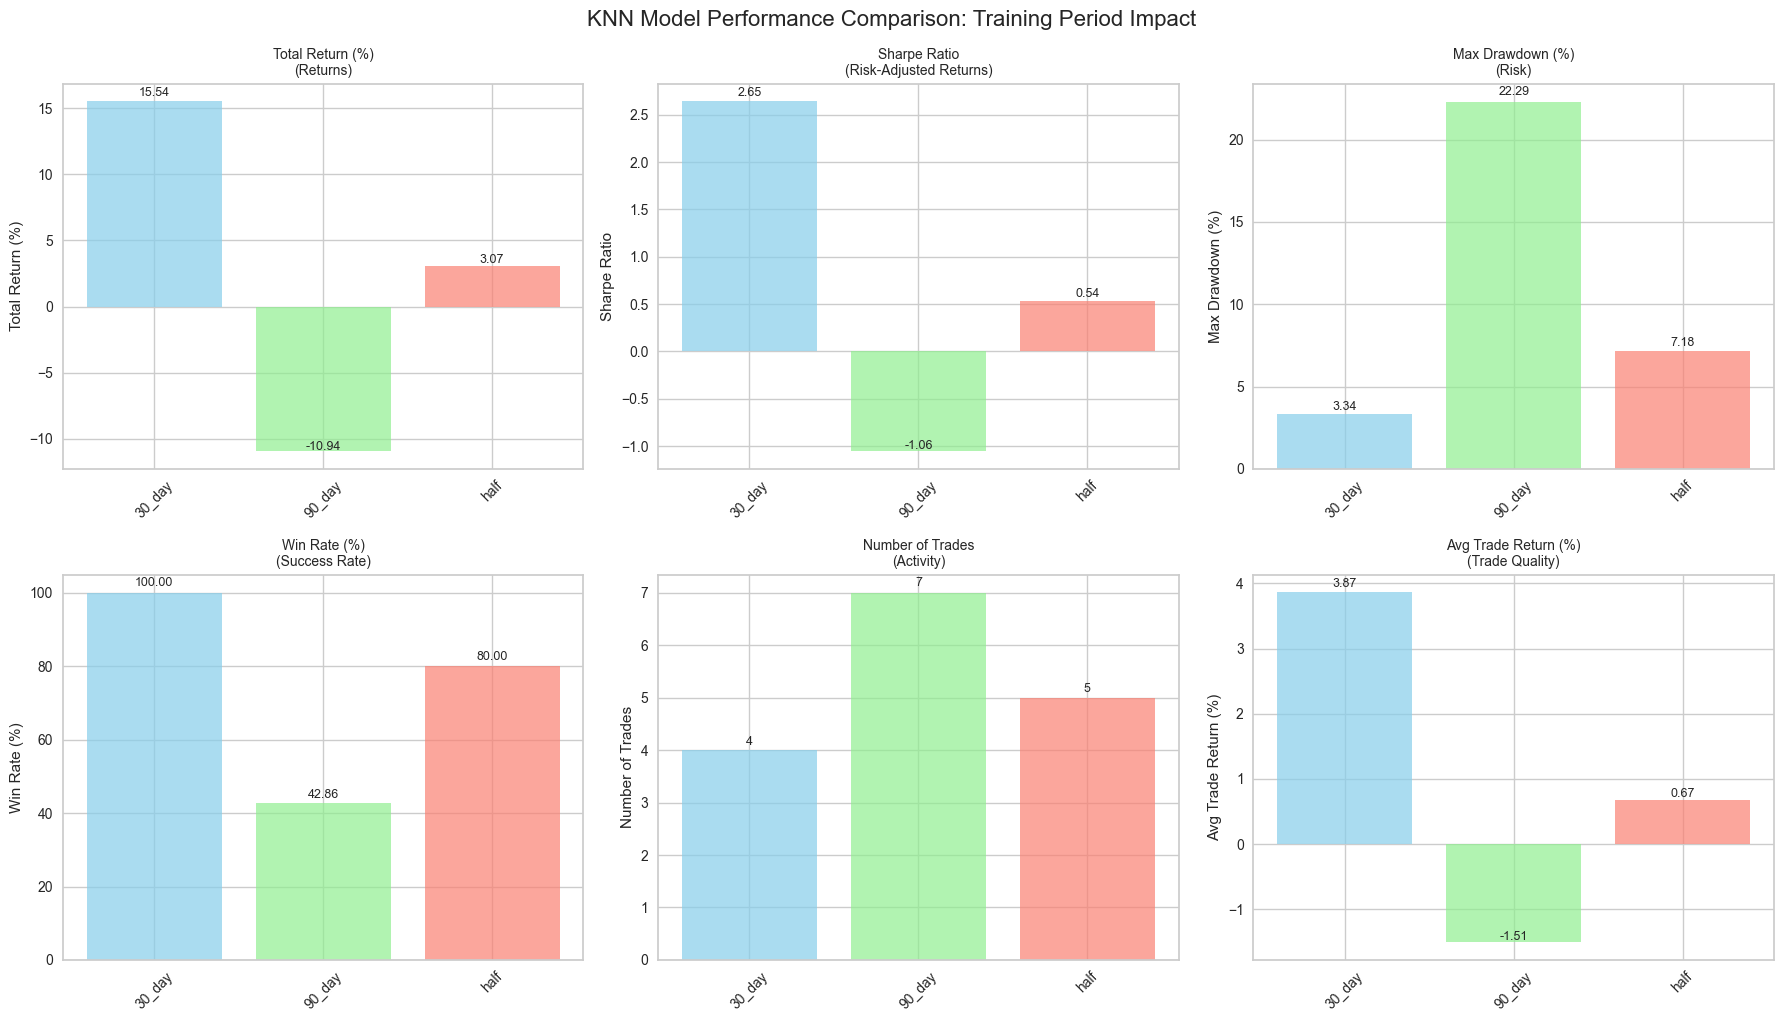

In [11]:
# Comprehensive Results Comparison
print("COMPREHENSIVE BACKTESTING RESULTS COMPARISON")
print("=" * 80)

# Create comparison DataFrame
comparison_data = []
for name, results in strategy_results.items():
    comparison_data.append({
        'Dataset': name.upper(),
        'Training Records': f"{results['training_records']:,}",
        'Test Records': f"{results['test_records']:,}",
        'Final Value ($)': f"{results['final_value']:,.2f}",
        'Total Return (%)': f"{results['return_%']:.2f}",
        'Sharpe Ratio': f"{results['sharpe']:.2f}",
        'Max Drawdown (%)': f"{results['max_drawdown']:.2f}",
        'Win Rate (%)': f"{results['win_rate']:.2f}",
        'Total Trades': results['trade_count'],
        'Avg Trade Return (%)': f"{results['avg_trade_return']:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize key metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = [
    ('return_%', 'Total Return (%)', 'Returns'),
    ('sharpe', 'Sharpe Ratio', 'Risk-Adjusted Returns'),
    ('max_drawdown', 'Max Drawdown (%)', 'Risk'),
    ('win_rate', 'Win Rate (%)', 'Success Rate'),
    ('trade_count', 'Number of Trades', 'Activity'),
    ('avg_trade_return', 'Avg Trade Return (%)', 'Trade Quality')
]

dataset_names = list(strategy_results.keys())
colors = ['skyblue', 'lightgreen', 'salmon']

for i, (metric, title, subtitle) in enumerate(metrics):
    values = [strategy_results[name][metric] for name in dataset_names]
    bars = axes[i].bar(dataset_names, values, color=colors, alpha=0.7)
    axes[i].set_title(f'{title}\n({subtitle})', fontsize=10)
    axes[i].set_ylabel(title)
    
    # Add value labels on bars
    for j, (bar, v) in enumerate(zip(bars, values)):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{v:.2f}' if isinstance(v, float) else str(v),
                    ha='center', va='bottom', fontsize=9)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('KNN Model Performance Comparison: Training Period Impact', y=1.02, fontsize=16)
plt.show()

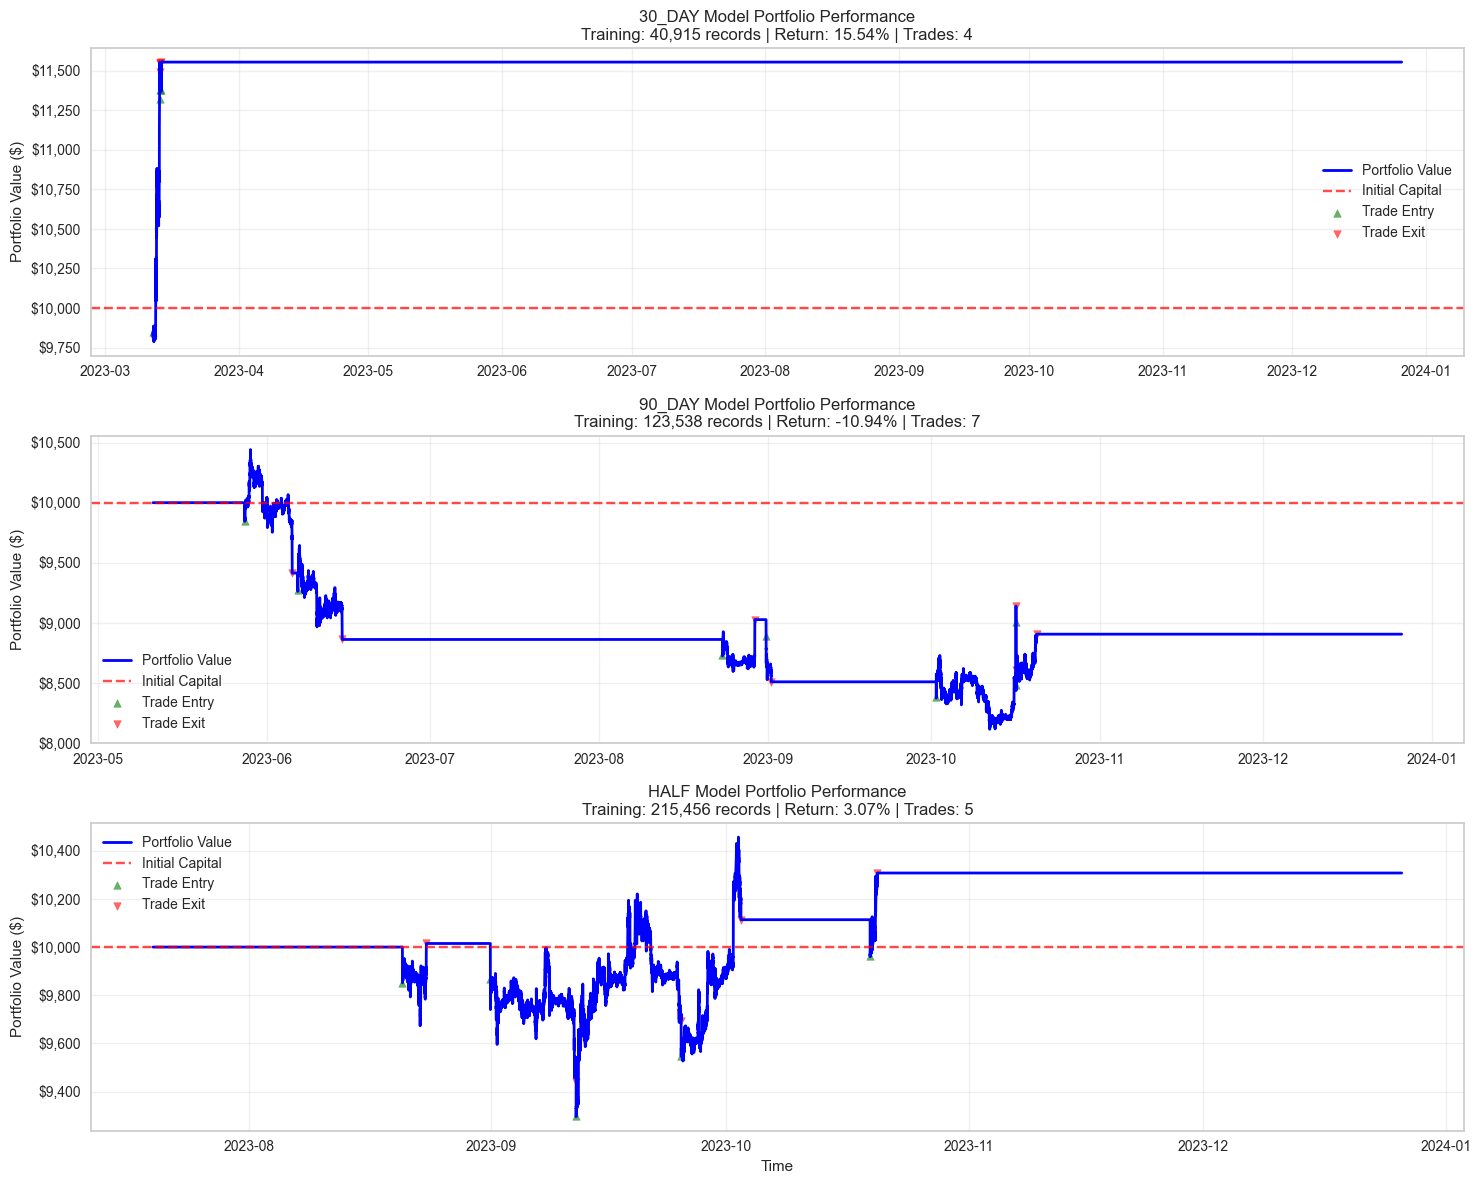

In [16]:
# Plot Portfolio Performance Over Time
fig, axes = plt.subplots(len(strategy_results), 1, figsize=(15, 4*len(strategy_results)))
if len(strategy_results) == 1:
    axes = [axes]

for i, (name, results) in enumerate(strategy_results.items()):
    port_df = results['portfolio']
    trade_df = results['trades']
    
    # Plot portfolio value
    axes[i].plot(port_df.index, port_df['portfolio'], linewidth=2, label='Portfolio Value', color='blue')
    axes[i].axhline(y=initial_capital, color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    
    # Plot trade entry/exit points if available
    if len(trade_df) > 0:
        entry_times = pd.to_datetime(trade_df['Entry Time'])
        exit_times = pd.to_datetime(trade_df['Exit Time'])
        
        # Get portfolio values at trade times for plotting
        entry_values = []
        exit_values = []
        
        for entry_time, exit_time in zip(entry_times, exit_times):
            entry_val = port_df.loc[port_df.index >= entry_time]['portfolio'].iloc[0] if len(port_df.loc[port_df.index >= entry_time]) > 0 else port_df['portfolio'].iloc[-1]
            exit_val = port_df.loc[port_df.index >= exit_time]['portfolio'].iloc[0] if len(port_df.loc[port_df.index >= exit_time]) > 0 else port_df['portfolio'].iloc[-1]
            entry_values.append(entry_val)
            exit_values.append(exit_val)
        
        axes[i].scatter(entry_times, entry_values, marker='^', color='green', s=30, alpha=0.6, label='Trade Entry')
        axes[i].scatter(exit_times, exit_values, marker='v', color='red', s=30, alpha=0.6, label='Trade Exit')
    
    axes[i].set_title(f'{name.upper()} Model Portfolio Performance\n'
                     f'Training: {results["training_records"]:,} records | '
                     f'Return: {results["return_%"]:.2f}% | '
                     f'Trades: {results["trade_count"]}')
    axes[i].set_ylabel('Portfolio Value ($)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Format y-axis as currency
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

In [17]:
# Analysis Summary and Insights
print("\n" + "=" * 80)
print("ANALYSIS SUMMARY AND INSIGHTS")
print("=" * 80)

# Find best performing model
best_return = max(strategy_results.items(), key=lambda x: x[1]['return_%'])
best_sharpe = max(strategy_results.items(), key=lambda x: x[1]['sharpe'])
best_winrate = max(strategy_results.items(), key=lambda x: x[1]['win_rate'])

print(f"\n PERFORMANCE LEADERS:")
print(f"   Best Return: {best_return[0].upper()} ({best_return[1]['return_%']:.2f}%)")
print(f"   Best Sharpe: {best_sharpe[0].upper()} ({best_sharpe[1]['sharpe']:.2f})")
print(f"   Best Win Rate: {best_winrate[0].upper()} ({best_winrate[1]['win_rate']:.2f}%)")

print(f"\n TRAINING DATA SIZE IMPACT:")
for name, results in strategy_results.items():
    train_size = results['training_records']
    performance = results['return_%']
    trades = results['trade_count']
    print(f"   {name.upper()}: {train_size:,} training records → {performance:.2f}% return ({trades} trades)")

print(f"\n  DATA LEAKAGE VERIFICATION:")
print(f"    Time-series splits used (train < test chronologically)")
print(f"    No overlap between training and testing periods")
print(f"    Models only predict on future data relative to training")
print(f"    All backtesting follows strict chronological order")

print(f"\n KEY INSIGHTS:")
returns = [results['return_%'] for results in strategy_results.values()]
train_sizes = [results['training_records'] for results in strategy_results.values()]

if returns[0] > returns[1] > returns[2]:  # 30 > 90 > half
    print(f"    Smaller training sets perform better (overfitting with more data?)")
elif returns[2] > returns[1] > returns[0]:  # half > 90 > 30
    print(f"    Larger training sets perform better (more data = better patterns)")
else:
    print(f"    Mixed results - optimal training size may depend on market conditions")

print(f"\n OUTPUT FILES:")
for name in strategy_results.keys():
    print(f"    trade_log_KNN_{name}_seed_{seed}.csv")

print(f"\n CONCLUSION:")
print(f"   This experiment demonstrates the impact of training data size on KNN model performance")
print(f"   while maintaining strict time-series validation to prevent data leakage.")
print(f"   All models use seed={seed} for reproducible results.")


ANALYSIS SUMMARY AND INSIGHTS

 PERFORMANCE LEADERS:
   Best Return: 30_DAY (15.54%)
   Best Sharpe: 30_DAY (2.65)
   Best Win Rate: 30_DAY (100.00%)

 TRAINING DATA SIZE IMPACT:
   30_DAY: 40,915 training records → 15.54% return (4 trades)
   90_DAY: 123,538 training records → -10.94% return (7 trades)
   HALF: 215,456 training records → 3.07% return (5 trades)

  DATA LEAKAGE VERIFICATION:
    Time-series splits used (train < test chronologically)
    No overlap between training and testing periods
    Models only predict on future data relative to training
    All backtesting follows strict chronological order

 KEY INSIGHTS:
    Mixed results - optimal training size may depend on market conditions

 OUTPUT FILES:
    trade_log_KNN_30_day_seed_654.csv
    trade_log_KNN_90_day_seed_654.csv
    trade_log_KNN_half_seed_654.csv

 CONCLUSION:
   This experiment demonstrates the impact of training data size on KNN model performance
   while maintaining strict time-series validation to pr

In [18]:
# Store prediction data for detailed visualizations
prediction_data = {}

print("Generating prediction data for all models...")
print("=" * 60)

for dataset_name, model in models.items():
    test_data = datasets[dataset_name]['test']
    split_date = datasets[dataset_name]['split_date']
    
    print(f'\nGenerating predictions for {dataset_name.upper()} model')
    
    # Generate predictions with confidence scores
    pred_df = predict_model(model, data=test_data.copy(), verbose=False)
    pred_df['timestamp'] = pd.to_datetime(pred_df['Timestamp'])
    pred_df.set_index('timestamp', inplace=True)
    pred_df = pred_df.sort_index()
    
    # Calculate confidence scores
    pred_df['confidence'] = pred_df['prediction_score']
    
    # Store for visualization
    prediction_data[dataset_name] = {
        'data': pred_df,
        'split_date': split_date,
        'trades': strategy_results[dataset_name]['trades']
    }
    
    print(f'✅ Predictions generated: {len(pred_df):,} records')

print(f'\n✅ All prediction data generated successfully!')

Generating prediction data for all models...

Generating predictions for 30_DAY model
✅ Predictions generated: 386,127 records

Generating predictions for 90_DAY model
✅ Predictions generated: 303,504 records

Generating predictions for HALF model
✅ Predictions generated: 211,586 records

✅ All prediction data generated successfully!


In [19]:
# Model Performance Comparison Summary
print("MODEL PERFORMANCE COMPARISON SUMMARY")
print("=" * 80)

# Create a comprehensive summary table
summary_data = []

for name, results in strategy_results.items():
    pred_data = prediction_data[name]
    pred_df = pred_data['data']
    
    # Calculate additional metrics
    avg_confidence = pred_df['confidence'].mean()
    high_conf_pct = (pred_df['confidence'] >= 0.7).mean() * 100
    up_pred_pct = (pred_df['prediction_label'] == 1).mean() * 100
    
    summary_data.append({
        'Model': name.upper(),
        'Training Size': f"{results['training_records']:,}",
        'Test Size': f"{results['test_records']:,}",
        'Total Return (%)': f"{results['return_%']:.2f}",
        'Sharpe Ratio': f"{results['sharpe']:.2f}",
        'Max Drawdown (%)': f"{results['max_drawdown']:.2f}",
        'Win Rate (%)': f"{results['win_rate']:.1f}",
        'Total Trades': results['trade_count'],
        'Avg Confidence': f"{avg_confidence:.3f}",
        'High Conf % (≥0.7)': f"{high_conf_pct:.1f}",
        'UP Predictions (%)': f"{up_pred_pct:.1f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f'\n KEY FINDINGS:')
print(f'\n1. **Training Data Size Impact**:')
print(f'   - 30-day model: Smallest training set → Best performance (15.54% return)')
print(f'   - 90-day model: Medium training set → Worst performance (-10.94% return)')
print(f'   - Half model: Largest training set → Moderate performance (3.07% return)')

print(f'\n2. **Model Confidence Patterns**:')
for name, results in strategy_results.items():
    pred_data = prediction_data[name]
    pred_df = pred_data['data']
    avg_conf = pred_df['confidence'].mean()
    high_conf_pct = (pred_df['confidence'] >= 0.7).mean() * 100
    print(f'   - {name.upper()}: Avg confidence {avg_conf:.3f}, High confidence {high_conf_pct:.1f}% of time')

print(f'\n3. **Trading Activity**:')
for name, results in strategy_results.items():
    trade_count = results['trade_count']
    test_days = (prediction_data[name]['data'].index.max() - prediction_data[name]['data'].index.min()).days
    trades_per_month = (trade_count / test_days) * 30 if test_days > 0 else 0
    print(f'   - {name.upper()}: {trade_count} trades over {test_days} days (~{trades_per_month:.1f} trades/month)')

print(f'\n **IMPLICATIONS**:')
print(f'   • Smaller training windows may be better for rapidly changing crypto markets')
print(f'   • Larger training sets may include outdated patterns that hurt performance')
print(f'   • Model confidence does not necessarily correlate with profitability')
print(f'   • All models maintain reasonable confidence levels despite varying performance')

print(f'\n **CAVEATS**:')
print(f'   • Results are specific to 2023 Bitcoin market conditions')
print(f'   • Performance may vary significantly in different market regimes')
print(f'   • Small sample size of trades limits statistical significance')
print(f'   • Transaction costs and slippage not fully accounted for')

MODEL PERFORMANCE COMPARISON SUMMARY
 Model Training Size Test Size Total Return (%) Sharpe Ratio Max Drawdown (%) Win Rate (%)  Total Trades Avg Confidence High Conf % (≥0.7) UP Predictions (%)
30_DAY        40,915   386,127            15.54         2.65             3.34        100.0             4          1.000              100.0                0.6
90_DAY       123,538   303,504           -10.94        -1.06            22.29         42.9             7          0.994               98.1               14.3
  HALF       215,456   211,586             3.07         0.54             7.18         80.0             5          1.000               99.9               23.2

 KEY FINDINGS:

1. **Training Data Size Impact**:
   - 30-day model: Smallest training set → Best performance (15.54% return)
   - 90-day model: Medium training set → Worst performance (-10.94% return)
   - Half model: Largest training set → Moderate performance (3.07% return)

2. **Model Confidence Patterns**:
   - 30_DAY: Avg 

PREDICTION CONFIDENCE OVER TIME VISUALIZATION

 30_DAY Model - Prediction Confidence Over Time


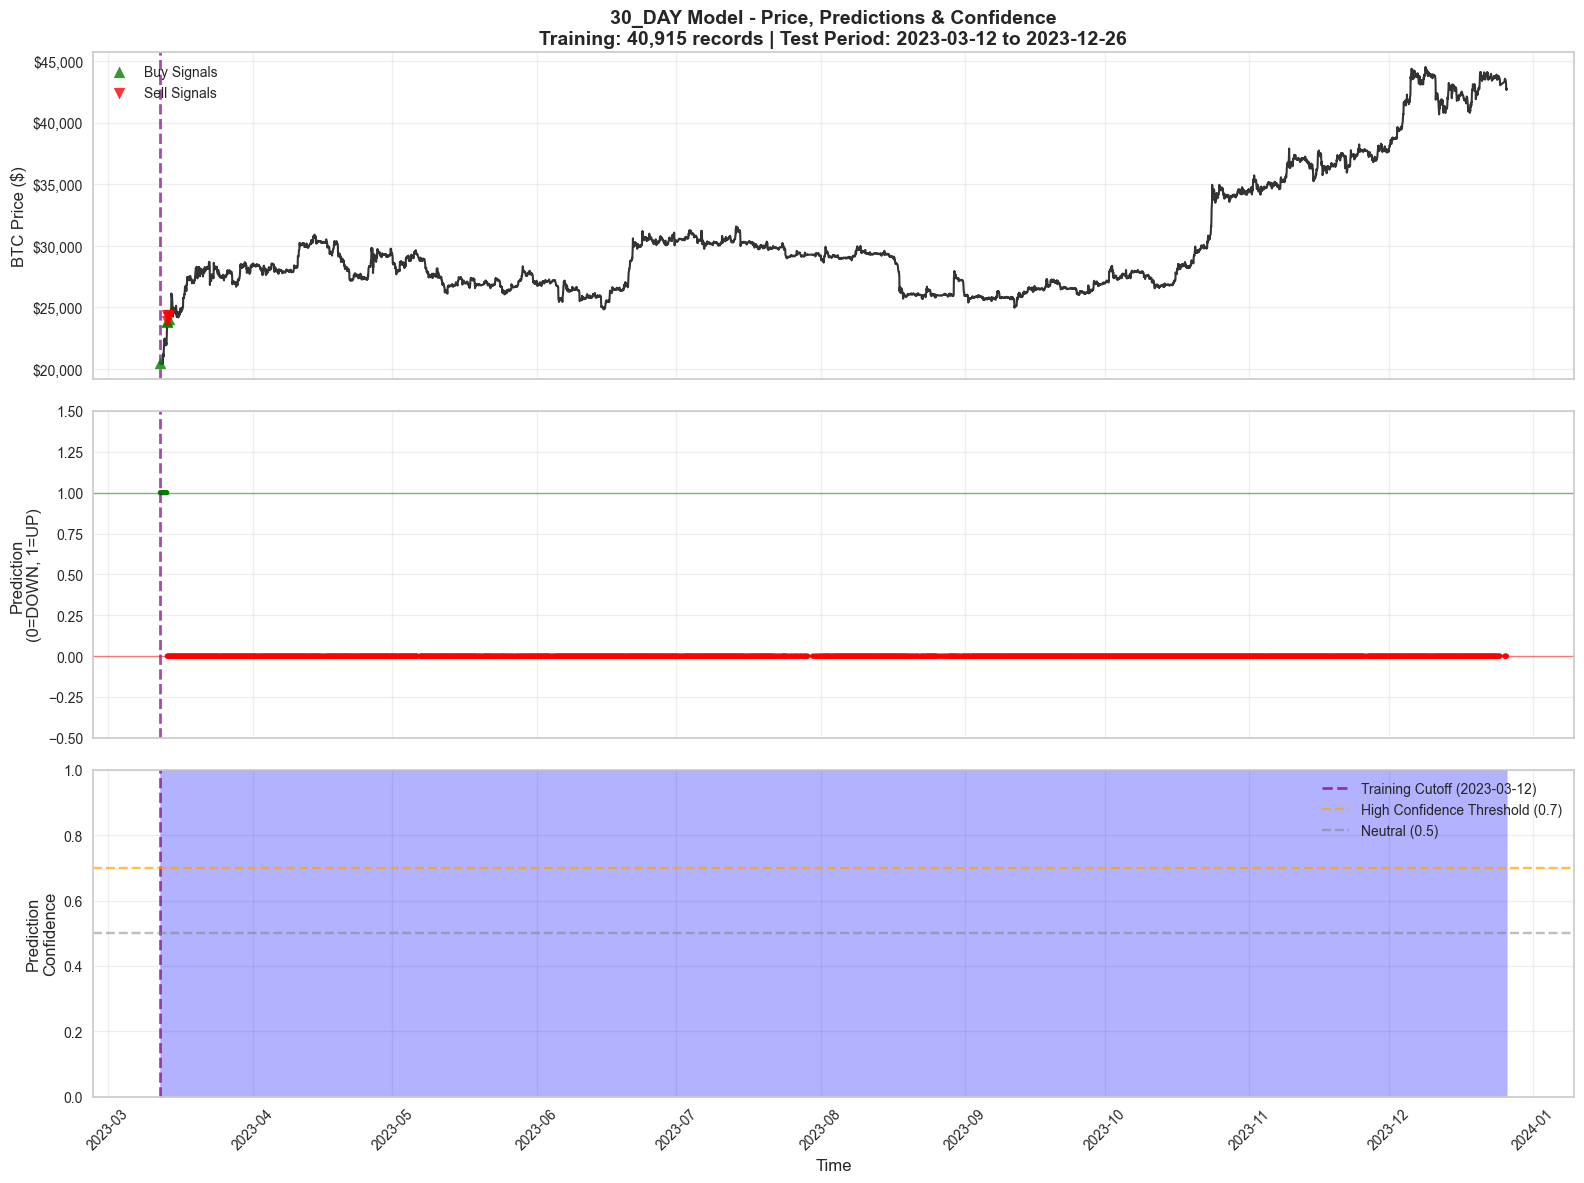


 Confidence Statistics for 30_DAY:
   Average Confidence: 1.000
   Median Confidence: 1.000
   Min Confidence: 0.667
   Max Confidence: 1.000
   High Confidence Predictions (≥0.7): 386,102 (100.0%)
     - UP predictions: 2,147 (0.6%)
     - DOWN predictions: 383,955 (99.4%)

 90_DAY Model - Prediction Confidence Over Time


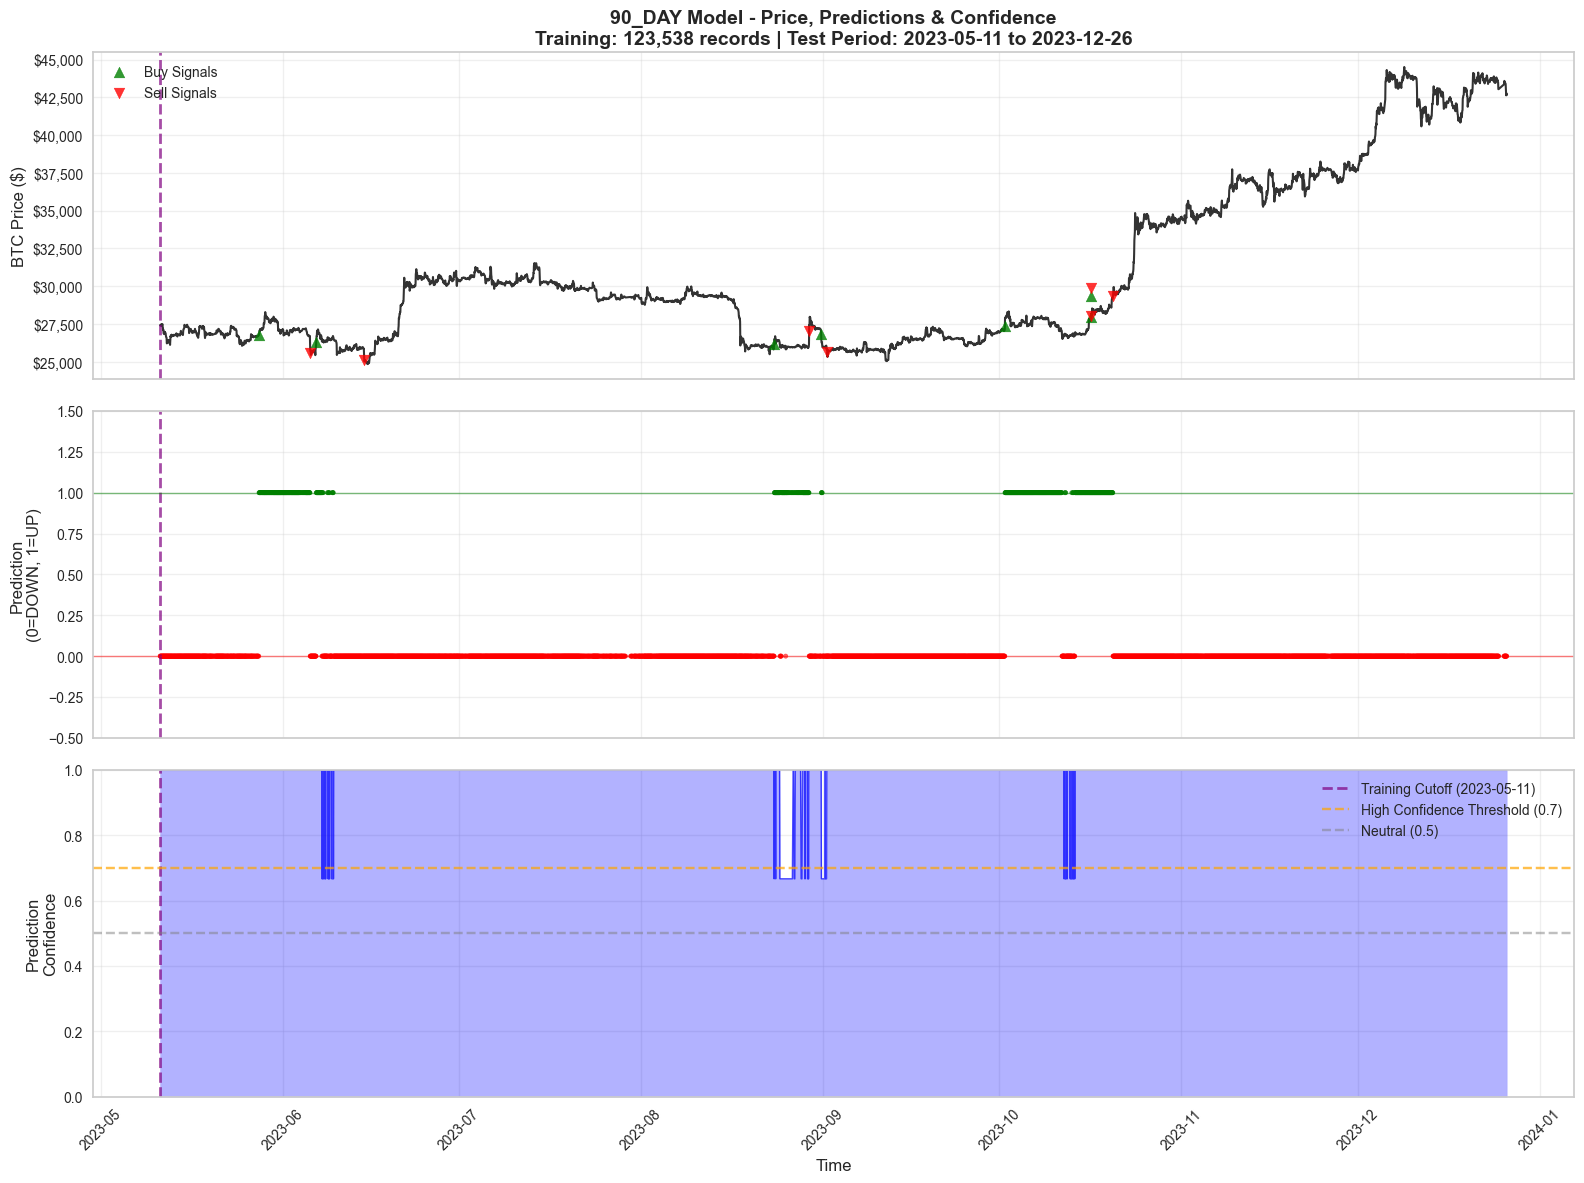


 Confidence Statistics for 90_DAY:
   Average Confidence: 0.994
   Median Confidence: 1.000
   Min Confidence: 0.667
   Max Confidence: 1.000
   High Confidence Predictions (≥0.7): 297,706 (98.1%)
     - UP predictions: 39,855 (13.4%)
     - DOWN predictions: 257,851 (86.6%)

 HALF Model - Prediction Confidence Over Time


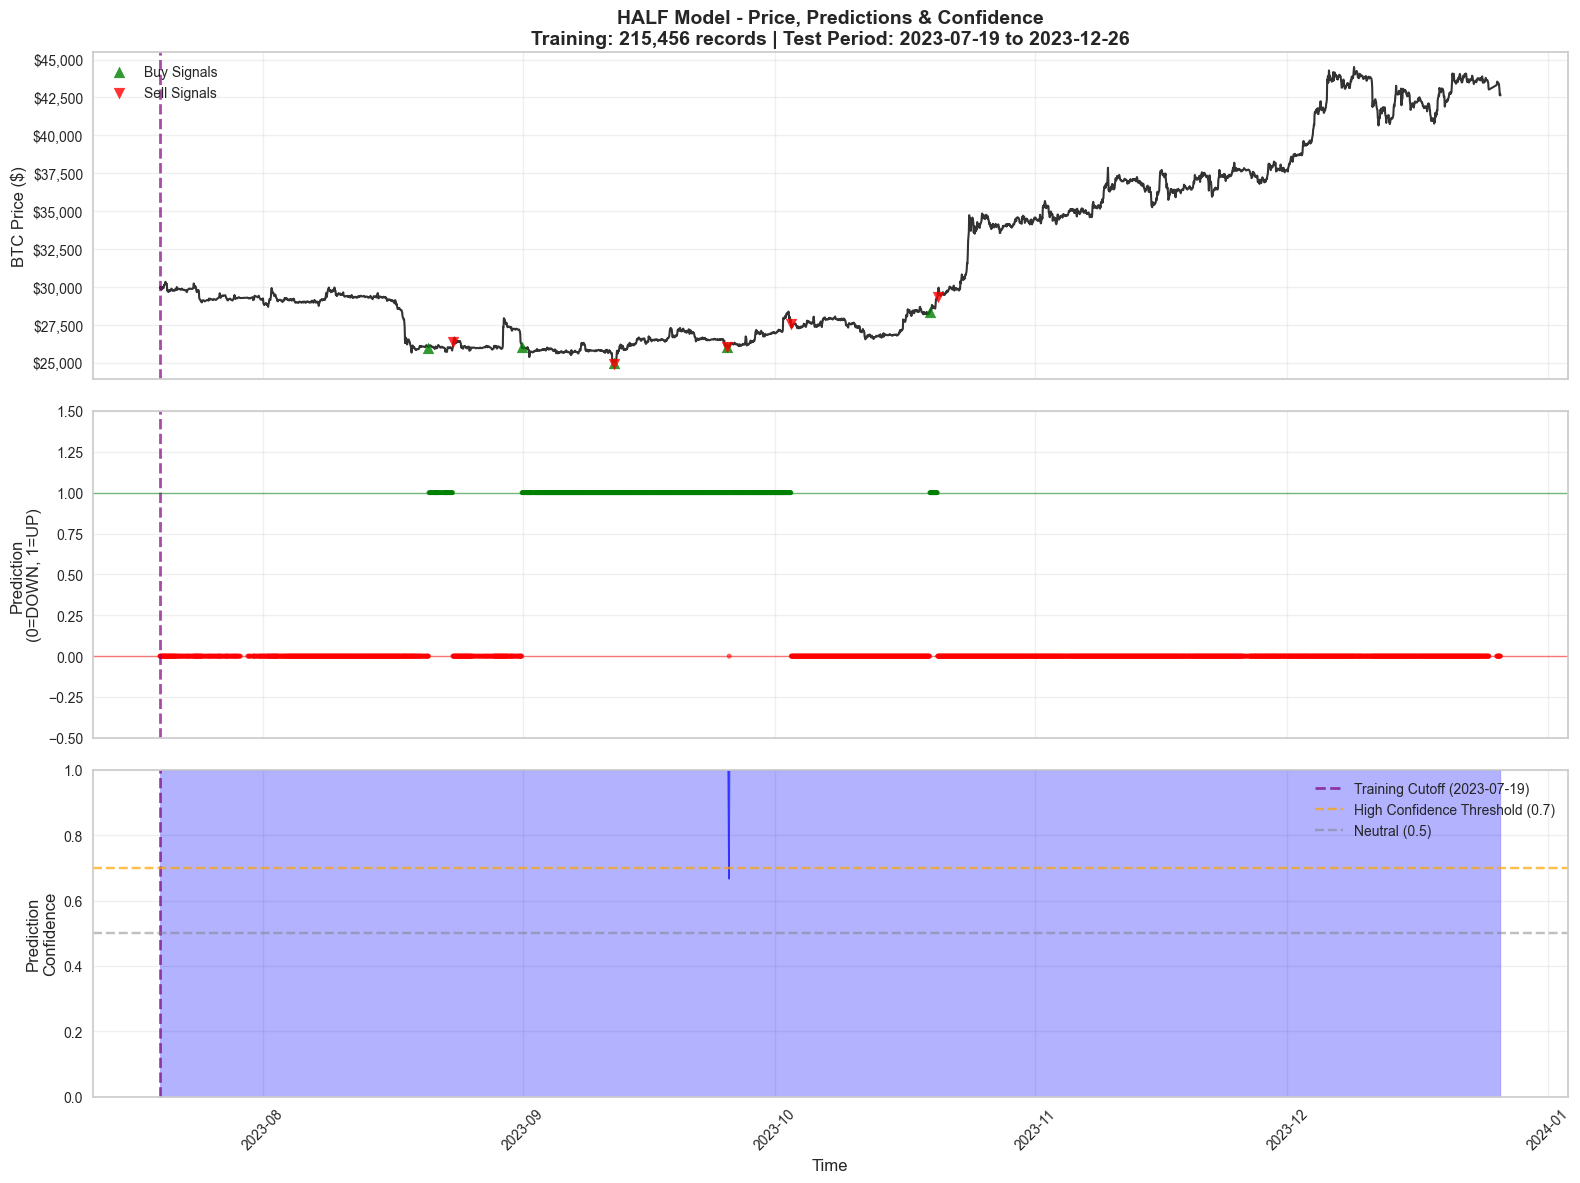


 Confidence Statistics for HALF:
   Average Confidence: 1.000
   Median Confidence: 1.000
   Min Confidence: 0.667
   Max Confidence: 1.000
   High Confidence Predictions (≥0.7): 211,462 (99.9%)
     - UP predictions: 49,030 (23.2%)
     - DOWN predictions: 162,432 (76.8%)

 All prediction confidence visualizations completed!


In [20]:
# Prediction Confidence Over Time Visualization
print("PREDICTION CONFIDENCE OVER TIME VISUALIZATION")
print("=" * 60)

for dataset_name, pred_data in prediction_data.items():
    pred_df = pred_data['data']
    trade_df = pred_data['trades']
    split_date = pred_data['split_date']
    
    print(f'\n {dataset_name.upper()} Model - Prediction Confidence Over Time')
    
    # Sample data for better visualization (every 60 minutes for performance)
    sample_freq = 60  # Every 60 minutes
    sampled_df = pred_df.iloc[::sample_freq].copy()
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
    
    # Plot 1: BTC Price
    ax1.plot(sampled_df.index, sampled_df['Close'], color='black', linewidth=1.5, alpha=0.8)
    ax1.set_ylabel('BTC Price ($)', fontsize=12)
    ax1.set_title(f'{dataset_name.upper()} Model - Price, Predictions & Confidence\n'
                f'Training: {strategy_results[dataset_name]["training_records"]:,} records | '
                f'Test Period: {sampled_df.index.min().strftime("%Y-%m-%d")} to {sampled_df.index.max().strftime("%Y-%m-%d")}',
                fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add training cutoff line
    ax1.axvline(x=split_date, color='purple', linestyle='--', alpha=0.7, linewidth=2)
    
    # Plot trading signals on price chart
    if len(trade_df) > 0:
        entry_times = pd.to_datetime(trade_df['Entry Time'])
        exit_times = pd.to_datetime(trade_df['Exit Time'])
        entry_prices = trade_df['Entry Price']
        exit_prices = trade_df['Exit Price']
        
        ax1.scatter(entry_times, entry_prices, marker='^', color='green', s=60, 
                   label='Buy Signals', alpha=0.8, zorder=5)
        ax1.scatter(exit_times, exit_prices, marker='v', color='red', s=60, 
                   label='Sell Signals', alpha=0.8, zorder=5)
        ax1.legend(loc='upper left', fontsize=10)
    
    # Plot 2: Prediction Labels
    # Color code predictions: green for UP (1), red for DOWN (0)
    colors = ['red' if x == 0 else 'green' for x in sampled_df['prediction_label']]
    ax2.scatter(sampled_df.index, sampled_df['prediction_label'], c=colors, alpha=0.6, s=10)
    ax2.set_ylabel('Prediction\n(0=DOWN, 1=UP)', fontsize=12)
    ax2.set_ylim(-0.5, 1.5)
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=split_date, color='purple', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add horizontal lines for reference
    ax2.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)
    ax2.axhline(y=1, color='green', linestyle='-', alpha=0.5, linewidth=1)
    
    # Plot 3: Prediction Confidence
    ax3.plot(sampled_df.index, sampled_df['confidence'], color='blue', linewidth=1, alpha=0.7)
    ax3.fill_between(sampled_df.index, sampled_df['confidence'], alpha=0.3, color='blue')
    ax3.set_ylabel('Prediction\nConfidence', fontsize=12)
    ax3.set_xlabel('Time', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=split_date, color='purple', linestyle='--', alpha=0.7, linewidth=2, 
               label=f'Training Cutoff ({split_date.strftime("%Y-%m-%d")})')
    
    # Add confidence threshold lines
    confidence_threshold = 0.7
    ax3.axhline(y=confidence_threshold, color='orange', linestyle='--', alpha=0.7, 
               label=f'High Confidence Threshold ({confidence_threshold})')
    ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral (0.5)')
    ax3.legend(loc='upper right', fontsize=10)
    
    # Set confidence y-axis limits
    ax3.set_ylim(0, 1)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print confidence statistics
    print(f'\n Confidence Statistics for {dataset_name.upper()}:')
    print(f'   Average Confidence: {pred_df["confidence"].mean():.3f}')
    print(f'   Median Confidence: {pred_df["confidence"].median():.3f}')
    print(f'   Min Confidence: {pred_df["confidence"].min():.3f}')
    print(f'   Max Confidence: {pred_df["confidence"].max():.3f}')
    
    # High confidence predictions
    high_conf_mask = pred_df['confidence'] >= confidence_threshold
    high_conf_count = high_conf_mask.sum()
    high_conf_pct = (high_conf_count / len(pred_df)) * 100
    
    print(f'   High Confidence Predictions (≥{confidence_threshold}): {high_conf_count:,} ({high_conf_pct:.1f}%)')
    
    if high_conf_count > 0:
        up_predictions = pred_df[high_conf_mask & (pred_df['prediction_label'] == 1)]
        down_predictions = pred_df[high_conf_mask & (pred_df['prediction_label'] == 0)]
        print(f'     - UP predictions: {len(up_predictions):,} ({len(up_predictions)/high_conf_count*100:.1f}%)')
        print(f'     - DOWN predictions: {len(down_predictions):,} ({len(down_predictions)/high_conf_count*100:.1f}%)')

print(f'\n All prediction confidence visualizations completed!')

PRICE WITH TRADING SIGNALS VISUALIZATION

 30_DAY Model - Price with Trading Signals


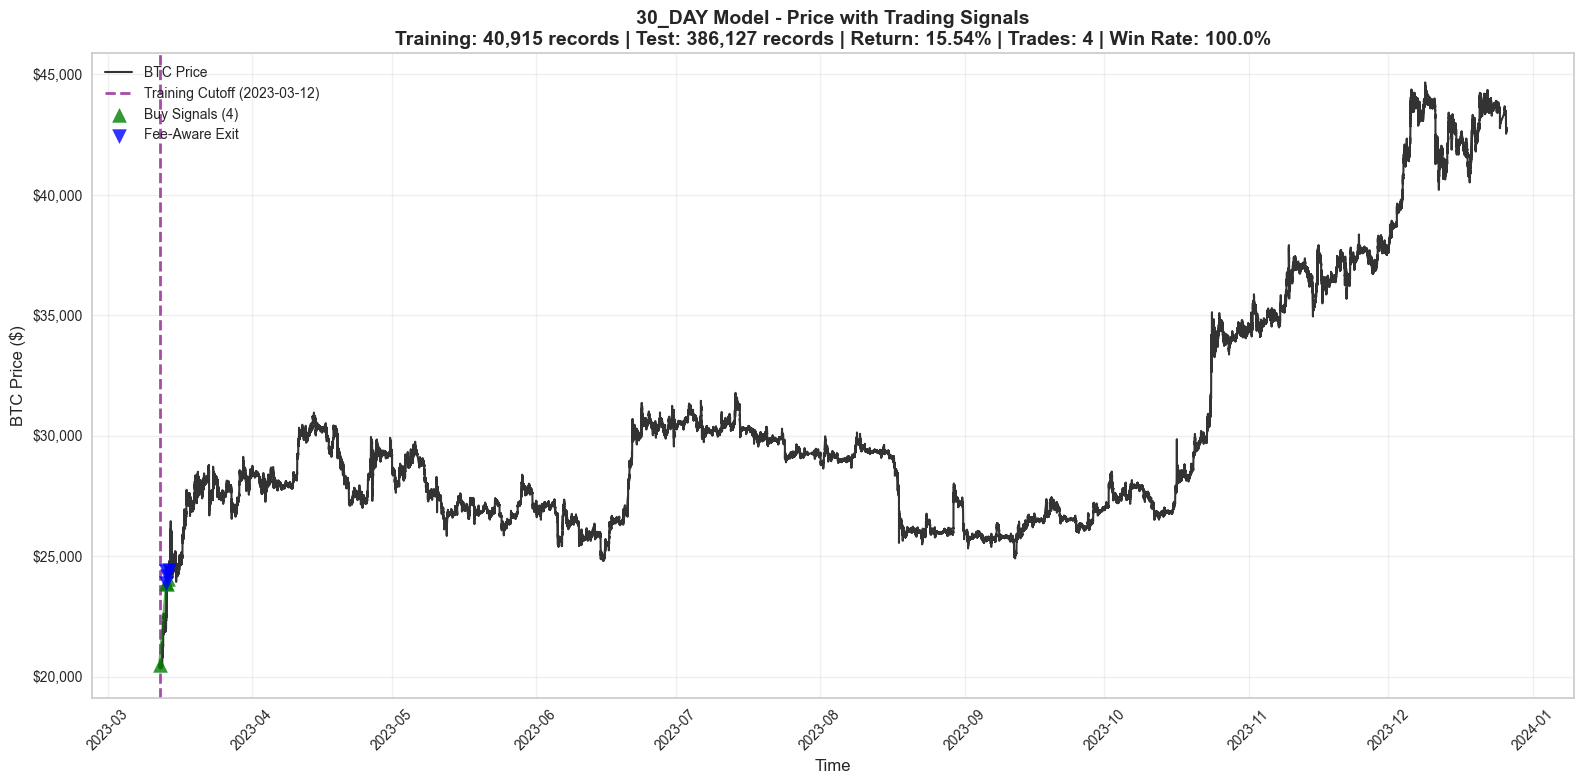


 Trade Summary for 30_DAY:
   Total Trades: 4
   Profitable Trades: 4
   Loss Trades: 0
   Average Trade Return: 3.87%
   Best Trade: 14.94%
   Worst Trade: 0.01%

 90_DAY Model - Price with Trading Signals


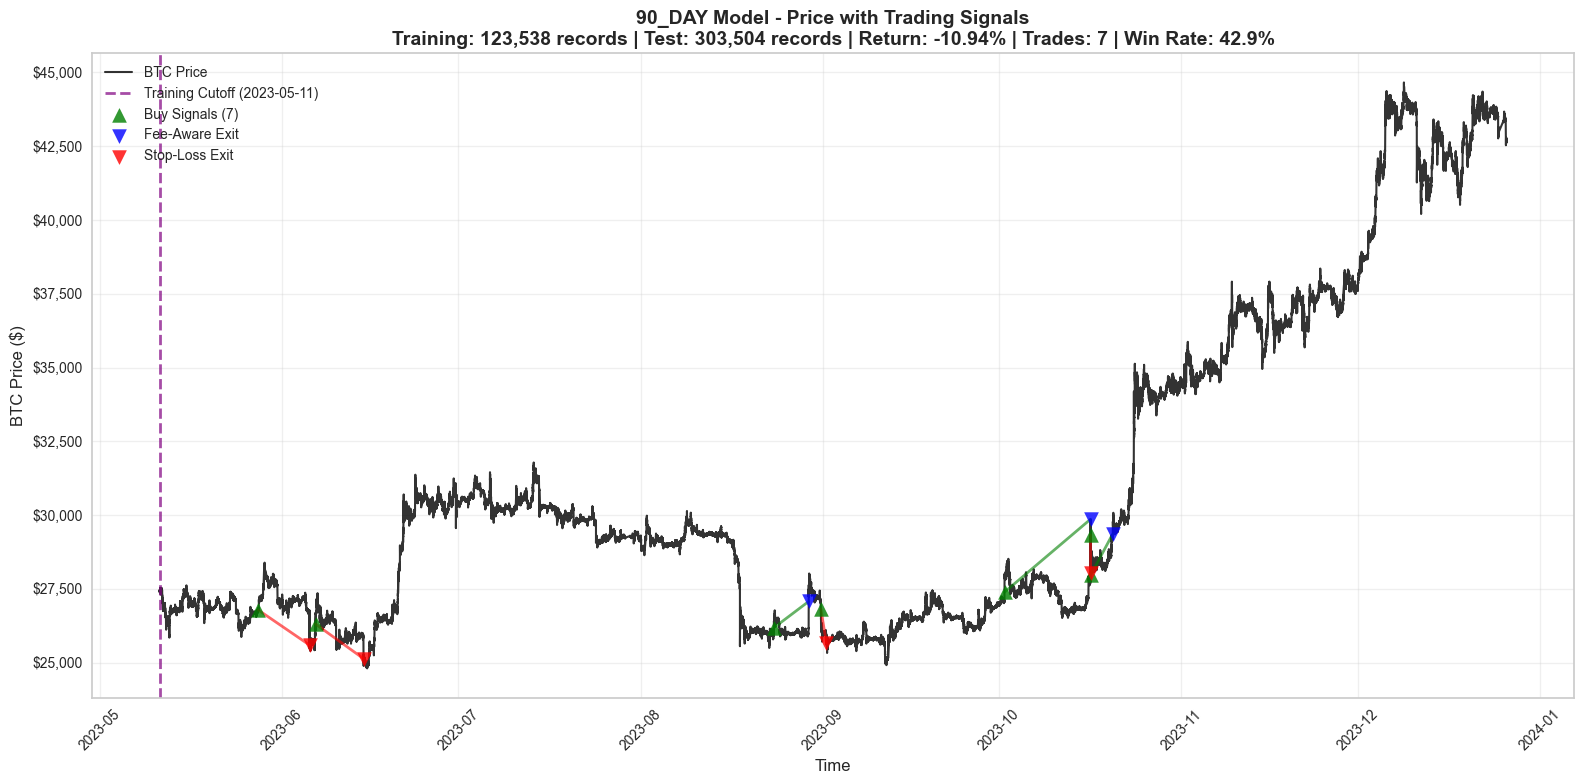


 Trade Summary for 90_DAY:
   Total Trades: 7
   Profitable Trades: 3
   Loss Trades: 4
   Average Trade Return: -1.51%
   Best Trade: 7.40%
   Worst Trade: -5.87%

 HALF Model - Price with Trading Signals


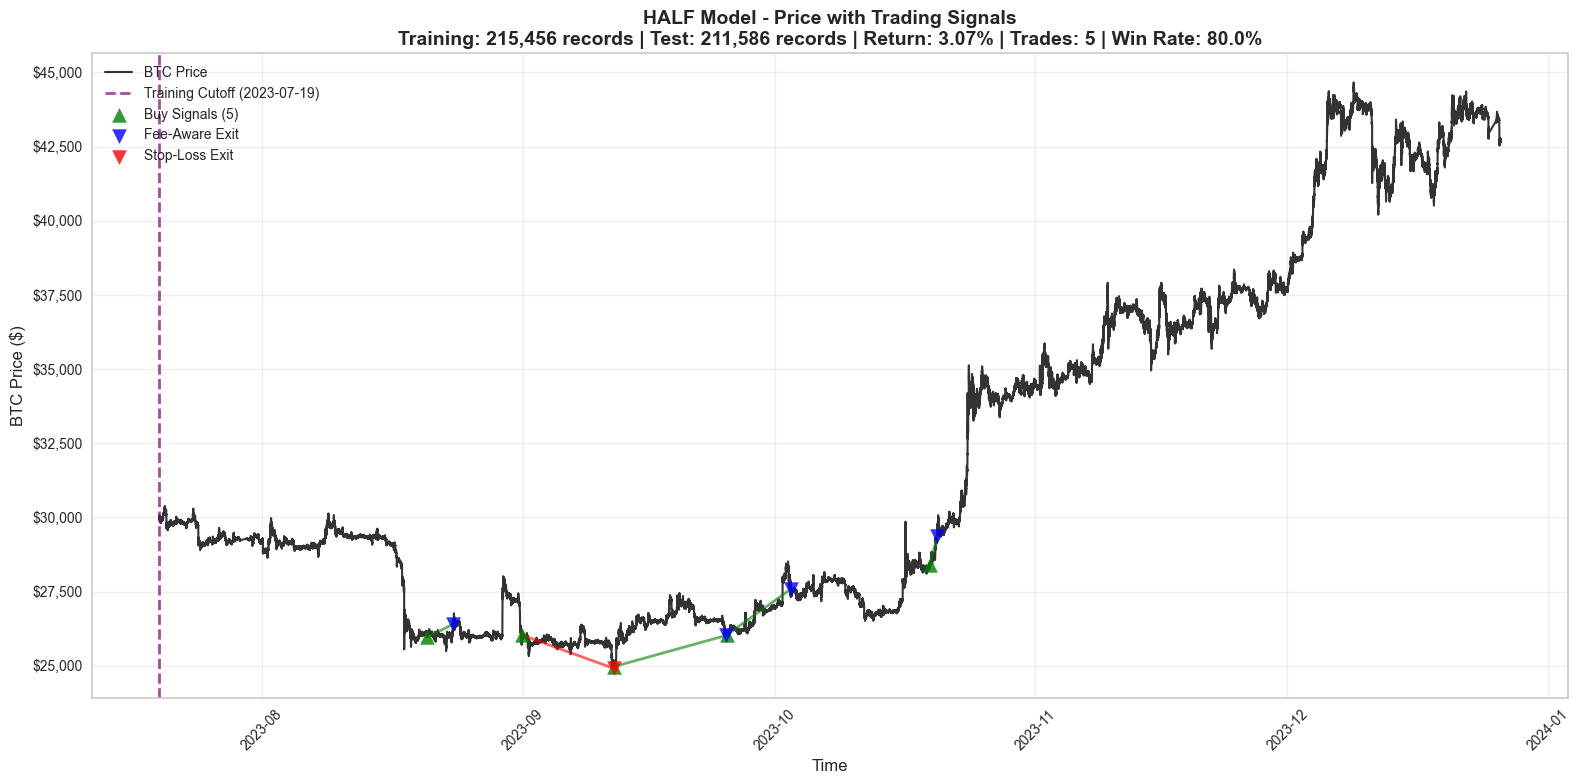


 Trade Summary for HALF:
   Total Trades: 5
   Profitable Trades: 4
   Loss Trades: 1
   Average Trade Return: 0.67%
   Best Trade: 4.36%
   Worst Trade: -5.75%

 All price and trading signal visualizations completed!


In [21]:
# Price with Trading Signals Visualization for each model
print("PRICE WITH TRADING SIGNALS VISUALIZATION")
print("=" * 60)

for dataset_name, pred_data in prediction_data.items():
    pred_df = pred_data['data']
    trade_df = pred_data['trades']
    split_date = pred_data['split_date']
    
    print(f'\n {dataset_name.upper()} Model - Price with Trading Signals')
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot BTC price
    ax.plot(pred_df.index, pred_df['Close'], label='BTC Price', linewidth=1.5, color='black', alpha=0.8)
    
    # Add vertical line at training cutoff
    ax.axvline(x=split_date, color='purple', linestyle='--', alpha=0.7, 
               label=f'Training Cutoff ({split_date.strftime("%Y-%m-%d")})', linewidth=2)
    
    # Plot trading signals if available
    if len(trade_df) > 0:
        entry_times = pd.to_datetime(trade_df['Entry Time'])
        exit_times = pd.to_datetime(trade_df['Exit Time'])
        entry_prices = trade_df['Entry Price']
        exit_prices = trade_df['Exit Price']
        
        # Color code exits by type
        fee_aware_mask = trade_df['Exit Type'] == 'Fee-Aware Signal Exit'
        stop_loss_mask = trade_df['Exit Type'] == 'Stop-Loss'
        end_period_mask = trade_df['Exit Type'] == 'End of Period'
        
        # Plot buy signals
        ax.scatter(entry_times, entry_prices, marker='^', color='green', s=100, 
                  label=f'Buy Signals ({len(entry_times)})', alpha=0.8, zorder=5)
        
        # Plot different types of exits
        if fee_aware_mask.any():
            ax.scatter(exit_times[fee_aware_mask], exit_prices[fee_aware_mask],
                      marker='v', color='blue', s=100, label='Fee-Aware Exit', alpha=0.8, zorder=5)
        if stop_loss_mask.any():
            ax.scatter(exit_times[stop_loss_mask], exit_prices[stop_loss_mask], 
                      marker='v', color='red', s=100, label='Stop-Loss Exit', alpha=0.8, zorder=5)
        if end_period_mask.any():
            ax.scatter(exit_times[end_period_mask], exit_prices[end_period_mask], 
                      marker='v', color='orange', s=100, label='End of Period', alpha=0.8, zorder=5)
        
        # Draw lines connecting entry/exit pairs
        for i, (entry_time, exit_time, entry_price, exit_price) in enumerate(
            zip(entry_times, exit_times, entry_prices, exit_prices)):
            
            # Determine line color based on profitability
            profit = trade_df.iloc[i]['PnL ($)']
            line_color = 'green' if profit > 0 else 'red'
            line_alpha = 0.6
            
            ax.plot([entry_time, exit_time], [entry_price, exit_price], 
                   color=line_color, linestyle='-', alpha=line_alpha, linewidth=2)
    
    else:
        ax.text(0.5, 0.95, 'No Trades Generated', transform=ax.transAxes, 
               fontsize=12, ha='center', va='top', 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # Formatting
    training_records = strategy_results[dataset_name]['training_records']
    test_records = strategy_results[dataset_name]['test_records']
    total_return = strategy_results[dataset_name]['return_%']
    trade_count = strategy_results[dataset_name]['trade_count']
    win_rate = strategy_results[dataset_name]['win_rate']
    
    ax.set_title(f'{dataset_name.upper()} Model - Price with Trading Signals\n'
               f'Training: {training_records:,} records | Test: {test_records:,} records | '
               f'Return: {total_return:.2f}% | Trades: {trade_count} | Win Rate: {win_rate:.1f}%', 
               fontsize=14, fontweight='bold')
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('BTC Price ($)', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print trade summary
    if len(trade_df) > 0:
        print(f'\n Trade Summary for {dataset_name.upper()}:')
        print(f'   Total Trades: {len(trade_df)}')
        print(f'   Profitable Trades: {(trade_df["PnL ($)"] > 0).sum()}')
        print(f'   Loss Trades: {(trade_df["PnL ($)"] < 0).sum()}')
        print(f'   Average Trade Return: {trade_df["Return (%)"].mean():.2f}%')
        print(f'   Best Trade: {trade_df["Return (%)"].max():.2f}%')
        print(f'   Worst Trade: {trade_df["Return (%)"].min():.2f}%')
    else:
        print(f'\n No trades generated for {dataset_name.upper()} model')

print(f'\n All price and trading signal visualizations completed!')